# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Final Project: Mobility Data and Coronavirus Cases in the United States

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2.4pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [171]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
import tensorflow as tf


In [131]:
# read in the dataframes
national_df = pd.read_csv("/US_Mobility_Report.csv")
state_df = pd.read_csv("/US_States_Mobility_Report.csv")
county_df = pd.read_csv("/US_Regional_Mobility_Report.csv")
cases_df = pd.read_csv("/covid_us_county.csv")

In [4]:
print(national_df.shape)
print(state_df.shape)
print(county_df.shape)
print(cases_df.shape)

(263, 7)
(13413, 8)
(68906, 10)
(237099, 9)


In [ ]:
county_df.head()

In [ ]:
cases_df.head()

In [5]:
# check for null columns
null_columns = cases_df.columns[cases_df.isnull().any()]
cases_df[null_columns].isnull().sum()

county        1132
cases            1
state_code    1982
deaths           1
dtype: int64

In [6]:
# drop all null columns
cases_df = cases_df.dropna()
cases_df.isnull().any()
# cases_df.loc[cases_df['state_code'].isnull()]

fips          False
county        False
state         False
lat           False
long          False
date          False
cases         False
state_code    False
deaths        False
dtype: bool

In [7]:
# get the date ranges for the mobility data
start_date = county_df.loc[county_df['census_fips_code'] == 1001]['date'][0]
end_date = county_df.loc[county_df['census_fips_code'] == 1001].tail()['date'].iloc[4]
print(start_date)
print(end_date)

2020-02-15
2020-11-03


In [8]:
# save raw dataframe for cases
cases_df_raw = cases_df.copy()

In [132]:
# county_df.groupby('census_fips_code')
county_df.rename(columns={"census_fips_code": "fips"}, inplace=True)

In [134]:
# county_df.groupby(by='census_fips_code').count()
county_df['fips'] = county_df['fips'].astype(int)
county_df.head()

,sub_region_1,sub_region_2,fips,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Alabama,Autauga County,1001,2020-02-15,5,7,34.0,-10.0,-4.0,7.0
1,Alabama,Autauga County,1001,2020-02-16,0,1,-23.0,-10.0,-4.0,7.0
2,Alabama,Autauga County,1001,2020-02-17,8,0,34.0,-10.0,-27.0,5.0
3,Alabama,Autauga County,1001,2020-02-18,-2,0,34.0,-10.0,2.0,0.0
4,Alabama,Autauga County,1001,2020-02-19,-2,0,34.0,-10.0,2.0,0.0


In [11]:
# for i in range(300): # for all the counties
  #  for j in range(257): # for all the days from February 15 to November 3
    #  county_df.set_value(i*j, i, )

In [12]:
cases_df['date'] == '2020-01-22'

0          True
1         False
2         False
3         False
4         False
          ...  
237093    False
237094    False
237095    False
237096    False
237097    False
Name: date, Length: 235117, dtype: bool

In [13]:
start_date_drop = cases_df.loc[cases_df['date'] == '2020-01-22'].index

In [14]:
end_date_drop = cases_df.loc[cases_df['date'] == start_date].index

In [15]:
# get the tail of dates to be dropped
last_date_drop = cases_df.loc[cases_df['date'] == end_date].index

In [16]:
print(len(start_date_drop))
print(len(end_date_drop))
print(len(last_date_drop))
num_counties = len(start_date_drop)
# the cases df ends sooner than the mobility df.

831
831
0


In [17]:
for i in range(831):
  cases_df = cases_df.drop(cases_df.iloc[start_date_drop[i]:end_date_drop[i]].index)

In [18]:
print(len(pd.unique(cases_df['fips'])))
print(len(pd.unique(county_df['census_fips_code'])))

831
300


In [138]:
cases_df['fips'] = cases_df['fips'].astype(int)
cases_df.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0.0,AL,0.0
1,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0.0,AL,0.0
2,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0.0,AL,0.0
3,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0.0,AL,0.0
4,1001,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0.0,AL,0.0


In [145]:
df = cases_df.merge(county_df)

In [147]:
df.loc[df['state'] != df['sub_region_1']]

,fips,county,state,lat,long,date,cases,state_code,deaths,sub_region_1,sub_region_2,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential


In [148]:
df.head()

,fips,county,state,lat,long,date,cases,state_code,deaths,sub_region_1,sub_region_2,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,1001,Autauga,Alabama,32.539527,-86.644082,2020-02-15,0.0,AL,0.0,Alabama,Autauga County,5,7,34.0,-10.0,-4.0,7.0
1,1001,Autauga,Alabama,32.539527,-86.644082,2020-02-16,0.0,AL,0.0,Alabama,Autauga County,0,1,-23.0,-10.0,-4.0,7.0
2,1001,Autauga,Alabama,32.539527,-86.644082,2020-02-17,0.0,AL,0.0,Alabama,Autauga County,8,0,34.0,-10.0,-27.0,5.0
3,1001,Autauga,Alabama,32.539527,-86.644082,2020-02-18,0.0,AL,0.0,Alabama,Autauga County,-2,0,34.0,-10.0,2.0,0.0
4,1001,Autauga,Alabama,32.539527,-86.644082,2020-02-19,0.0,AL,0.0,Alabama,Autauga County,-2,0,34.0,-10.0,2.0,0.0


In [149]:
# drop nulls
df = df.dropna()

In [150]:
# save raw df before work is done on it
df_raw = df.copy()

Now, hopefully, everything is matched up properly

In [151]:
# drop the lats and longs
df = df.drop(columns=['lat', 'long'])

In [152]:
df.head()

,fips,county,state,date,cases,state_code,deaths,sub_region_1,sub_region_2,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,1001,Autauga,Alabama,2020-02-15,0.0,AL,0.0,Alabama,Autauga County,5,7,34.0,-10.0,-4.0,7.0
1,1001,Autauga,Alabama,2020-02-16,0.0,AL,0.0,Alabama,Autauga County,0,1,-23.0,-10.0,-4.0,7.0
2,1001,Autauga,Alabama,2020-02-17,0.0,AL,0.0,Alabama,Autauga County,8,0,34.0,-10.0,-27.0,5.0
3,1001,Autauga,Alabama,2020-02-18,0.0,AL,0.0,Alabama,Autauga County,-2,0,34.0,-10.0,2.0,0.0
4,1001,Autauga,Alabama,2020-02-19,0.0,AL,0.0,Alabama,Autauga County,-2,0,34.0,-10.0,2.0,0.0


In [153]:
df.describe()

,fips,cases,deaths,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
count,67870.000000,67870.000000,67870.000000,67870.000000,67870.000000,67870.000000,67870.000000,67870.000000,67870.000000
mean,5142.030087,2509.070723,63.150965,-11.704155,0.483159,28.651481,-12.672241,-23.803418,7.505304
std,2910.863292,12684.687708,315.286394,17.706361,11.822019,33.517721,17.690115,14.856997,4.742235
min,1001.000000,0.000000,0.000000,-100.000000,-80.000000,-91.000000,-87.000000,-88.000000,-21.000000
25%,2130.000000,9.000000,0.000000,-20.000000,-4.000000,31.000000,-12.000000,-33.000000,6.000000
50%,5119.000000,154.000000,2.000000,-9.000000,2.000000,34.000000,-10.000000,-24.000000,7.000000
75%,6113.000000,1067.000000,22.000000,-3.000000,3.000000,34.000000,-10.000000,-15.000000,8.000000
max,12023.000000,306327.000000,7056.000000,140.000000,114.000000,501.000000,134.000000,26.000000,37.000000


In [154]:
# save all predictors in its own variable
all_predictors = ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential']

In [155]:
# split between predictors and response variables
X = df.drop(columns=['cases', 'deaths'])
y_cases = df['cases']
y_deaths = df['deaths']

In [156]:
# split between train and test data -- for covid cases
X_train_raw, X_test_raw, y_train_raw_cases, y_test_raw_cases = train_test_split(X, y_cases, test_size=0.3, random_state=111)
print(f"The shape of: \n"
      f"X_train is {X_train_raw.shape}\n"
      f"X_test is {X_test_raw.shape}\n"
      f"y_train is {y_train_raw_cases.shape}\n"
      f"y_test is {y_test_raw_cases.shape}\n")
X_train, X_test, y_train_cases, y_test_cases = X_train_raw, X_test_raw, y_train_raw_cases, y_test_raw_cases

The shape of: 
X_train is (47509, 13)
X_test is (20361, 13)
y_train is (47509,)
y_test is (20361,)



In [157]:
# split between train and test data -- for covid deaths
X_train_raw_deaths, X_test_raw_deaths, y_train_raw_deaths, y_test_raw_deaths = train_test_split(X, y_deaths, test_size=0.3, random_state=111)
print(f"The shape of: \n"
      f"X_train is {X_train_raw_deaths.shape}\n"
      f"X_test is {X_test_raw_deaths.shape}\n"
      f"y_train is {y_train_raw_deaths.shape}\n"
      f"y_test is {y_test_raw_deaths.shape}\n")
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = X_train_raw_deaths, X_train_raw_deaths, y_train_raw_deaths, y_test_raw_deaths

The shape of: 
X_train is (47509, 13)
X_test is (20361, 13)
y_train is (47509,)
y_test is (20361,)



In [55]:
# # scale the data for good measure
# # maybe late
# scaled = StandardScaler().fit(X_train_raw[all_predictors])
# X_train[all_predictors] = pd.DataFrame(scaled.transform(X_train_raw[all_predictors]), columns=X_train_raw[all_predictors].columns)
# X_test[all_predictors] = pd.DataFrame(scaled.transform(X_test_raw[all_predictors]), columns=X_test_raw[all_predictors].columns)
# y_train, y_test = y_train_raw_cases.astype(int), y_test_raw_cases.astype(int)

In [158]:
N=X_test.shape[0]

In [159]:
%%time
# N= 5000
logit_basic = LogisticRegression(penalty="none")
logit_basic.fit(X_train[all_predictors].head(N), y_train_cases.head(N))


CPU times: user 10min 45s, sys: 34.4 s, total: 11min 19s
Wall time: 9min 47s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [160]:
%%time
logit_basic_train_accuracy = logit_basic.score(X_train[all_predictors].head(N), y_train_cases.head(N))
logit_basic_test_accuracy = logit_basic.score(X_test[all_predictors].head(N), y_test_cases.head(N))

print(logit_basic_train_accuracy)
print(logit_basic_test_accuracy)

0.14242915377437257
0.14233092677176956
CPU times: user 1.41 s, sys: 215 ms, total: 1.62 s
Wall time: 1.07 s


In [32]:
|

0.335
0.165


In [161]:
%%time
logit_basic_deaths = LogisticRegression(penalty="none")
logit_basic_deaths.fit(X_train_deaths[all_predictors].head(N), y_train_deaths.head(N))


CPU times: user 1min 43s, sys: 12.8 s, total: 1min 55s
Wall time: 1min 33s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [162]:
%%time
logit_basic_train_accuracy_deaths = logit_basic_deaths.score(X_train_deaths[all_predictors].head(N), y_train_deaths.head(N))
logit_basic_test_accuracy_deaths = logit_basic_deaths.score(X_test_deaths[all_predictors].head(N), y_test_deaths.head(N))

print(logit_basic_train_accuracy_deaths)
print(logit_basic_test_accuracy_deaths)

0.34477677913658467
0.3394234074947203
CPU times: user 310 ms, sys: 130 ms, total: 440 ms
Wall time: 231 ms


In [163]:
%%time
# N=5000
predictor_ca_deaths_train = {}
predictor_ca_deaths_test = {}
for predictor in all_predictors:

  logit_basic_deaths = LogisticRegression(penalty="none")
  logit_basic_deaths.fit(X_train_deaths[[predictor]].head(N), y_train_deaths.head(N))

  logit_basic_train_accuracy_deaths = logit_basic_deaths.score(X_train_deaths[[predictor]].head(N), y_train_deaths.head(N))
  logit_basic_test_accuracy_deaths = logit_basic_deaths.score(X_test_deaths[[predictor]].head(N), y_test_deaths.head(N))
  predictor_ca_deaths_train.update([(predictor, logit_basic_train_accuracy_deaths)])
  predictor_ca_deaths_test.update([(predictor, logit_basic_test_accuracy_deaths)])

  # print(logit_basic_train_accuracy_deaths)
  # print(logit_basic_test_accuracy_deaths)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


CPU times: user 9min 39s, sys: 1min 6s, total: 10min 45s
Wall time: 9min 22s


In [164]:
print(predictor_ca_deaths_train)
print(" ")
print(predictor_ca_deaths_test)

{'retail_and_recreation': 0.3558764304307254, 'grocery_and_pharmacy': 0.3577427434801827, 'parks': 0.3521438043318108, 'transit_stations': 0.3582829919944993, 'workplaces': 0.34502234664309217, 'residential': 0.3581356514905948}
 
{'retail_and_recreation': 0.3654044496832179, 'grocery_and_pharmacy': 0.3678601247482933, 'parks': 0.3507195127940671, 'transit_stations': 0.3659446981975345, 'workplaces': 0.3403074505181474, 'residential': 0.3611315750699867}


It looks like all the predictors have about the same classification accuracy.

Let's try a different type of model now

Top 2 PCA variance explained:  0.839
number of components that explain at least 90% of the variance= 3


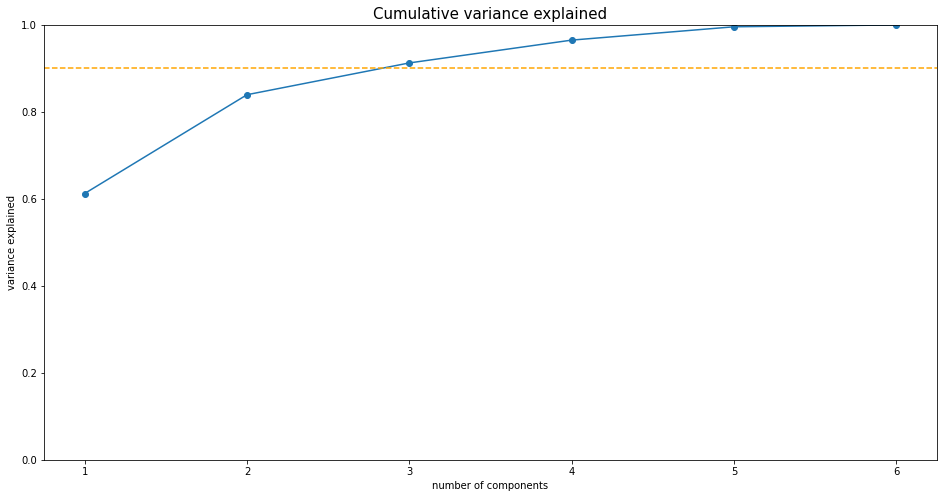

In [167]:
pca = PCA().fit(X_train_deaths[all_predictors])
pca_xtrain = pca.transform(X_train_deaths[all_predictors])
pca_xtest = pca.transform(X_test_deaths[all_predictors])

print( f'Top 2 PCA variance explained: {np.sum(pca.explained_variance_ratio_[0:2]): .3f}')

var_explained = []
total_comp = 6
pca = PCA(n_components = total_comp).fit(X_train_deaths[all_predictors])

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(range(1, total_comp+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.axhline(0.90, linestyle='--', color='orange')
ax.set_ylim(0,1)
ax.set_xlabel('number of components')
ax.set_ylabel('variance explained')
ax.set_title('Cumulative variance explained',fontsize=15)

print("number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<0.90)[0])+1)

As we can see, we need about half the components to explain at least 90% of the variance.

In [168]:
%%time
N=5000
component=6
pca = PCA(n_components = component).fit(X_train_deaths[all_predictors].head(N))  
X_train_pca = pca.transform(X_train_deaths[all_predictors].head(N))
X_test_pca = pca.transform(X_test_deaths[all_predictors].head(N))
    
logreg_pca = LogisticRegression(penalty='none', solver='lbfgs')
logreg_pca.fit(X_train_pca, y_train_deaths.head(N))

y_train_pred_logreg_pca = logreg_pca.predict(X_train_pca)
y_test_pred_logreg_pca = logreg_pca.predict(X_test_pca)
train_score = accuracy_score(y_train_deaths.head(N), y_train_pred_logreg_pca)
test_score = accuracy_score(y_test_deaths.head(N), y_test_pred_logreg_pca)

print(f'The training and testing classification accuracies are: {train_score: .4f} and {test_score: .4f}')

The training and testing classification accuracies are:  0.3496 and  0.3410
CPU times: user 20.5 s, sys: 11.3 s, total: 31.7 s
Wall time: 17.4 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    cv_scores = []
    
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        train_scores.append(clf.fit(X_train, y_train).score(X_train, y_train))
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
    # end of your code here
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train_deaths[all_predictors], y_train_deaths, depths)

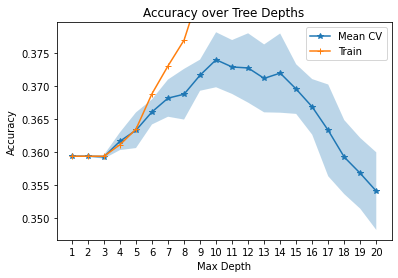

In [181]:
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.ylim(ylim)

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title("Accuracy over Tree Depths")
plt.xticks(depths);

Looks like the best depth is around 10. Let's make that tree again then.

In [185]:
best_depth = 10
fitted_tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train_deaths[all_predictors].head(N), y_train_deaths.head(N))
best_cv_tree_train_score = fitted_tree.score(X_train_deaths[all_predictors].head(N), y_train_deaths.head(N))
best_cv_tree_test_score = fitted_tree.score(X_test_deaths[all_predictors].head(N), y_test_deaths.head(N))
print(best_cv_tree_test_score)

0.2552


In [192]:
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.InputLayer(input_shape=X_train_deaths[all_predictors].shape[1])) # input layer
NN_model.add(tf.keras.layers.Dense(100, activation='relu',name='hidden-1'))
NN_model.add(tf.keras.layers.Dense(100, activation='relu',name='hidden-2'))
NN_model.add(tf.keras.layers.Dense(100, activation='relu',name='hidden-3'))
NN_model.add(tf.keras.layers.Dense(1, activation='sigmoid',name='output'))
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden-1 (Dense)             (None, 100)               700       
_________________________________________________________________
hidden-2 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden-3 (Dense)             (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 21,001
Trainable params: 21,001
Non-trainable params: 0
_________________________________________________________________


In [196]:
%%time
NN_model.compile(loss='binary_crossentropy', 
                 metrics=['accuracy'], 
                 optimizer=tf.keras.optimizers.Adam())
history = NN_model.fit(X_train_deaths[all_predictors], y_train_deaths, 
                              epochs=100, verbose=0, validation_split=0.3)

CPU times: user 3min 34s, sys: 24.4 s, total: 3min 59s
Wall time: 2min 36s


In [201]:
# take a quick look at the train accuracy 
train_accuracy_regular = NN_model.evaluate(X_train_deaths[all_predictors].head(N), y_train_deaths.head(N))[1]
test_accuracy_regular = NN_model.evaluate(X_test_deaths[all_predictors].head(N), y_test_deaths.head(N))[1]
print(f"Train accuracy is {train_accuracy_regular}, test accuracy is {test_accuracy_regular}")

157/157 [==============================] - 0s 944us/step - loss: -121140935563149312.0000 - accuracy: 0.0756
Train accuracy is 0.0820000022649765, test accuracy is 0.07559999823570251
